# Семинар. Вариационный автокодировщик.

В этом семинаре мы модифицируем наш автокодировщик до вариационного.

# Подгрузка импортов и датасета

In [ ]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [ ]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
_, labels = next(iter(dataloader))

# Вариационный автокодировщик

Как мы помним, вариационный автокодировщик отличается от обычного тем, что в нем задается структура латентного пространства. По предположению, внутреннее пространство автокодировщика задается нормальным распределением с параметрами $\mu, \sigma$. Эти параметры и будет выучивать вариационный автокодировщик.

Как будет выглядеть слой семплирования и кодирования в этом случае?

## Архитектура

In [ ]:
class CVAE(nn.Module):
    def __init__(self, num_classes=10, dim_code=32):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.mu = nn.Linear(6272, dim_code)
        self.log_var = nn.Linear(6272, dim_code)

        self.decoder_input = nn.Linear(dim_code + num_classes, 6272)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,  stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3,  stride=2, output_padding=1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )


    def encode(self, x):
        out = self.enc(x)
        mu = self.mu(out)
        log_var = self.log_var(out)
        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.distributions.Normal(0, 1).sample()
            return std * eps + mu
        else:
            return mu

    def decode(self, z, y):
        z = torch.cat([z, y], dim=-1)
        out = self.decoder_input(z)
        out = out.view(-1, 128, 7, 7)
        out = self.dec(out)
        return out

    def forward(self, x, y):
        mu, log_var = self.encode(x)
        z = self.gaussian_sampler(mu, log_var)
        out = self.decode(z, y)
        return out, mu, log_var

## Функция потерь

Вспомним, из чего состоит функция потерь вариационного кодировщика. Мы имеем два слагаемых: восстановление изображения и приближение распределения кодировщика к распределению данных. За восстановление отвечает MSE-составляющая, за второе слагаемое - KL-дивергенция.

$$\Bbb L = log(p_{\theta}(x|z)) - D_{KL} [ q_{\theta}(z|x)p(z) ]$$

$D_{KL}$ можем записать следующим образом:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

In [ ]:
class VAELoss(nn.Module):
    def __init__(self, kl_weight=1, mse_weight=1):
        super().__init__()
        self.kl_weight = kl_weight
        self.mse_weight = mse_weight
        self.mse = nn.MSELoss()

    def _kl_loss(self, mu, log_var):
        return torch.mean(- 1 / 2 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    def forward(self, x, reconstruction, mu, log_var):
        return self.kl_weight * self._kl_loss(mu, log_var) + self.mse_weight * self.mse(x, reconstruction)

## Функция обучения

In [ ]:
def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device):
    train_loss = []

    for i in range(epochs):
        model.to(device)
        model.train()
        train_epoch_loss = []
        tqdm_iter = tqdm(dataloader)
        for batch in tqdm_iter:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            labels = func.one_hot(labels, num_classes=10)

            optimizer.zero_grad()

            pred = model(images, labels)
            reconstructed, mu, log_var = pred
            loss = criterion(images, reconstructed, mu, log_var)

            loss.backward()
            optimizer.step()
            tqdm_iter.set_postfix(loss=f'{loss.item():.3f}')
        train_epoch_loss.append(loss.item())
        train_loss.append(np.mean(train_epoch_loss))
        tqdm_iter.set_postfix(loss=f'{train_loss[-1]:.5f}')
    return train_loss

## Определение параметров обучения

In [ ]:
criterion = VAELoss(kl_weight=0.6, mse_weight=1)
model = CVAE(dim_code=32, num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)
epochs = 30
device = 'mps'

100%|██████████| 1875/1875 [01:10<00:00, 26.76it/s, loss=0.024]


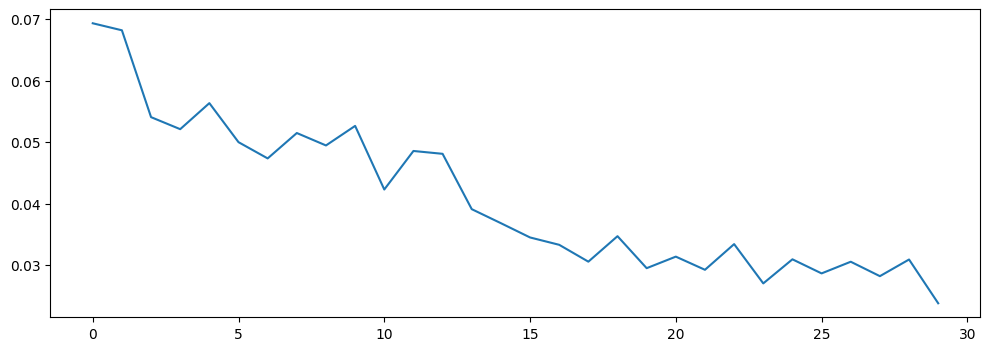

In [ ]:
loss = train_autoencoder(
    model=model,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.show()

# Визуализация результатов

In [ ]:
def visualize_compare_result(x, recon):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(recon, cmap='gray')
    plt.show()

## Посмотрим на результат обучения

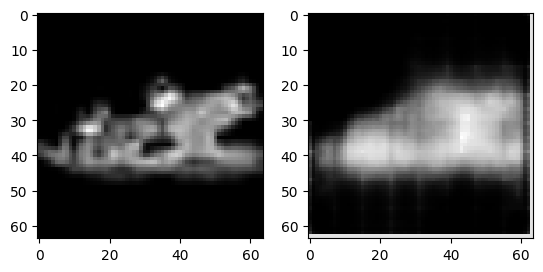

In [ ]:
X, y = next(iter(dataloader))
with torch.no_grad():
  y = func.one_hot(y, num_classes=10)
  reconstructed, mu, log_var = model(X.to(device), y.to(device))
recon = reconstructed[0].permute(1, 2, 0).cpu().detach().numpy()
x = X[0].permute(1, 2, 0).cpu().detach().numpy()
visualize_compare_result(x, recon)

## Просемплируем что-то новенькое

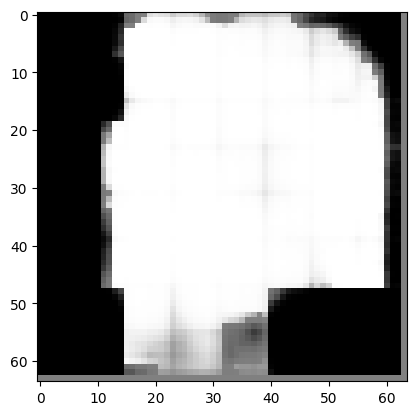

In [ ]:
model.eval()
z = torch.randn(1, 32)
y = torch.tensor(np.random.randint(0,2, size=(1,10)))
output = model.decode(z.to(device), y.to(device))
img = output[0].permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(img, cmap='gray')